<a href="https://colab.research.google.com/github/MikhailKuklin/time-series-analysis-forecasting/blob/main/notebooks/ts_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
# libraries

import numpy as np
import pandas as pd
from matplotlib import dates
from pylab import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
%matplotlib inline

In [120]:
# download data and parse date to datetime

df = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m","d"]})

df=df.drop_duplicates()

df.dropna(axis=0,inplace=True)

df = df.groupby(['date']).mean()

df.index.freq = "D"

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2020-01-01 to 2022-01-02
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Air temperature (degC)  733 non-null    float64
dtypes: float64(1)
memory usage: 11.5 KB


In [69]:
# rename column

df['Temperature (C)'] = df['Air temperature (degC)']
df.drop(['Air temperature (degC)'],axis=1, inplace=True)

In [132]:
# create training and test sets

df_train = df.iloc[:586]
df_test = df.iloc[585:]

In [150]:
# fit model

fitted_model = ExponentialSmoothing(df_train['Air temperature (degC)'],trend='add',seasonal='add',seasonal_periods=100).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [156]:
# make forecasting

test_predictions = fitted_model.forecast(148).rename('Forecast')

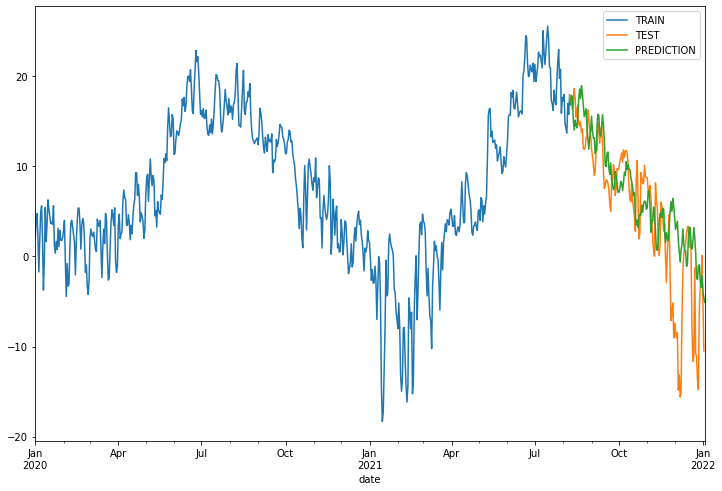

In [157]:
# plot forecasting and observations

df_train['Air temperature (degC)'].plot(legend=True,label='TRAIN')
df_test['Air temperature (degC)'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

Evaluation

In [158]:
# MAE
# Disadvantage: does not tell when it is completely off

mean_absolute_error(df_test,test_predictions)

3.660096538322963

In [159]:
# MSE
# Disadvantage: units are squared

mean_squared_error(df_test,test_predictions)

28.04966471246905

In [160]:
# RMSE

np.sqrt(mean_squared_error(df_test,test_predictions))

5.296193417207216

Stationarity and differencing

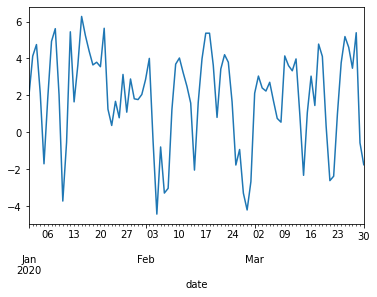

In [172]:
# extract part of the data which is stationary

df_s = df.iloc[:90]

df_s['Air temperature (degC)'].plot();

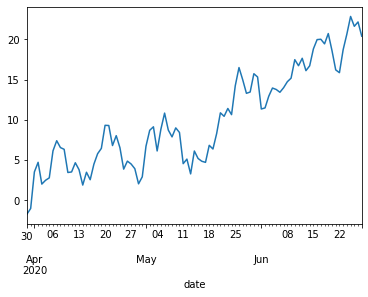

In [176]:
# non-stationary data

df_ns = df.iloc[89:180]

df_ns['Air temperature (degC)'].plot();

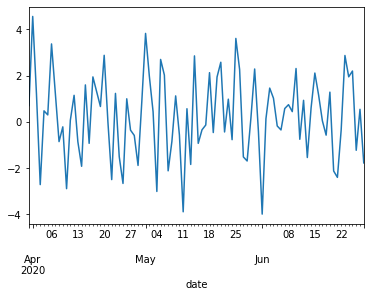

In [181]:
# create stationary data from non-stationary using first order differencing

diff(df_ns['Air temperature (degC)'],k_diff = 1).plot()